In [2]:
import os
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
from tqdm import tqdm
import rasterio

from shapely.geometry import Point,LineString
from shapely.geometry.polygon import Polygon

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier

import pickle
from joblib import dump, load

from sklearn import tree

In [3]:
# Compiled csv status
# This file should not be huge (>few hundres MB)
# It should be trimmed to only contain our 'training' data points i.e. mines + (non-mining data which we want to ensure is included in the fit/optimization)
# This file will probably be a combination of several regions, which is totally fine. 
# Ensure to include Australia data set and Mojave and a city as controls for false positive exclusion data
file = 'status_kibali_500m_29.56_3.1_29.615_3.155.csv'
df_kibali = pd.read_csv(file)
df = pd.read_csv(file)

file = 'status_musonoi_500m_25.34_-10.78_25.475_-10.675.csv'
df_musonoi = pd.read_csv(file)
df = pd.concat([df, df_musonoi], ignore_index=True)

file = 'status_kanunka_500m_27.355_-7.56_27.415_-7.51.csv'
df_kanunka = pd.read_csv(file)
df = pd.concat([df, df_kanunka], ignore_index=True)

file = 'status_australia_500m_122.17_-21.77_122.255_-21.695.csv'
df_australia = pd.read_csv(file)
df = pd.concat([df, df_australia], ignore_index=True)


In [4]:
# Let us define true mining areas that are within our pre-defined polygons
# This file can again contain many polygons that can be in a number of regions, not necessarily the same one.
polyfile = 'polygons.txt' 
with open(polyfile,'r') as f:
    data = f.readlines()
npoly = len(data)
polygon = []

In [5]:
for i in range(npoly):
    poly = data[i].split('\n')[0]
    poly = poly.split(' ')
    npts = len(poly)
    lon = []
    lat = []
    for j in range(npts-1):
        x = poly[j].split(',')
        lon_x = x[0]
        lat_x = x[1]
        lon.append(lon_x)
        lat.append(lat_x)
    lon = np.array(lon,dtype=np.float64)
    lat = np.array(lat,dtype=np.float64)

    lons_lats_vect = np.column_stack((lon, lat))
    polygon.append(Polygon(lons_lats_vect)) 


In [6]:
def reduce_region(df,mine_pos):
    """
    args:
    df: dataframe
    mine_pos: indices of variables we wish to return. It is a vector.
    return:
    min_lon,min_lat,max_lon,max_lat,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio
    at the indices
    """
    min_lon = df['Mininum Longitude'][mine_pos].values
    min_lat = df['Minimum Latitude'][mine_pos].values
    max_lon = df['Maximum Longitude'][mine_pos].values
    max_lat = df['Maximum Latitude'][mine_pos].values
    mine_veg_loss = df['Percent Vegetation Loss'][mine_pos].values
    bare_initial = df['Percent Bare Initial'][mine_pos].values
    sar = df['Percent Significant VH Values'][mine_pos].values
    nirg = df['Average NIR/G'][mine_pos].values
    swir1 = df['Average SWIR1/B'][mine_pos].values
    nasa_elev = df['NASA Elev'][mine_pos].values
    gedi_loss = df['Elev Loss'][mine_pos].values
    gedi_qual = df['GEDI Qual. Flag'][mine_pos].values
    b5 = df['B5 Value'][mine_pos].values
    b6 = df['B6 Value'][mine_pos].values
    ndmi = df['NDMI'][mine_pos].values
    elev_score = df['Elevation Score'][mine_pos].values
    band_ratio = df['Band Variation Score'][mine_pos].values
    calc_status = df['Status'][mine_pos].values
    b5_std = df['B5 Std'][mine_pos].values
    b6_std = df['B6 Std'][mine_pos].values


    return(min_lon,min_lat,max_lon,max_lat,mine_veg_loss,bare_initial,sar,\
           nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,\
           elev_score,band_ratio,ndmi,calc_status,b5_std,b6_std)

In [7]:
# Here we are simply extracting all of our data from the pandas dataframe
idf=np.ones(df.shape[0])
idf = np.where(idf==1)[0]


# Get variables
lon_min,lat_min,lon_max,lat_max,mine_veg_loss,bare_initial,sar,\
nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,\
band_ratio,ndmi,calc_stat,b5_std,b6_std = reduce_region(df,idf)

In [8]:
import time 
import multiprocessing
from multiprocessing import Pool

tz = time.time()

npts = len(lon_min)
npoly = len(polygon)


def looper(i):
    point_ll = Point(lon_min[i],lat_min[i])
    point_ur = Point(lon_max[i],lat_max[i])
    for j in range(npoly):
        within1 = polygon[j].contains(point_ll)
        within2 = polygon[j].contains(point_ur)
        if(within1==True or within2==True):
            return i
    return np.nan

y = np.linspace(0,npts-1,npts)
y = np.array(y,dtype=int)
y = list(y)
pool = Pool(multiprocessing.cpu_count())                        
d1 = pool.map(looper, y)

        
pool.close() 
pool.join()

print(time.time() - tz)

171.46603894233704


In [9]:
d2 = np.array(d1)
idy = np.isfinite(d2)
idx = np.array(d2[idy],dtype=int)

# single execution = 4 mins 30 seconds. 863433 points
#MP = 2 mins 17 seconds.

In [10]:
npts = len(lon_min)
npoly = len(polygon)
"""
idx = []
for i in tqdm(range(npts)):
    point_ll = Point(lon_min[i],lat_min[i])
    point_ur = Point(lon_max[i],lat_max[i])
    done=False
    for j in range(npoly):
        within1 = polygon[j].contains(point_ll)
        within2 = polygon[j].contains(point_ur)
        if(within1==True or within2==True):
            if(done == False):
                done=True
                idx.append(i)
idx=np.array(idx,dtype=int)
"""

'\nidx = []\nfor i in tqdm(range(npts)):\n    point_ll = Point(lon_min[i],lat_min[i])\n    point_ur = Point(lon_max[i],lat_max[i])\n    done=False\n    for j in range(npoly):\n        within1 = polygon[j].contains(point_ll)\n        within2 = polygon[j].contains(point_ur)\n        if(within1==True or within2==True):\n            if(done == False):\n                done=True\n                idx.append(i)\nidx=np.array(idx,dtype=int)\n'

In [11]:
# Define mining regions with score of 1, non-mining=0
status = np.zeros(npts,dtype=int)
status[idx] = 1

In [49]:
# False positive data streams
"""
file = 'status_mojave_20m_-115.71_34.91_-115.66_34.93.csv'
df_mojave = pd.read_csv(file)
dg = pd.read_csv(file)

print(dg.shape)

file = 'LakeNzilo.csv'
df_water = pd.read_csv(file)

df_water.loc[df_water["Percent Significant VH Values"] >-19, "Percent Significant VH Values"] = 0
df_water.loc[df_water["Percent Significant VH Values"] <=-19, "Percent Significant VH Values"] = 100

df_water = df_water.assign(Status=np.zeros(df_water.shape[0]))


dg = pd.concat([dg, df_water], ignore_index=True)
print(dg.shape)

file = 'waterII_statusII_compiled_27_-11_27.1_-10.8.csv'
df_water2 = pd.read_csv(file)
dg = pd.concat([dg, df_water2], ignore_index=True)
print(dg.shape)
"""
file = 'status_farming_500m_26.85_-10.9_26.9_-10.95.csv'
df_farm = pd.read_csv(file)
dg = df_farm#pd.concat([dg, df_farm], ignore_index=True)
print(dg.shape)


(77284, 27)


In [50]:
# Here we are simply extracting all of our data from the pandas dataframe
idg=np.ones(dg.shape[0])
idg = np.where(idg==1)[0]


# Get variables
glon_min,glat_min,glon_max,glat_max,gmine_veg_loss,gbare_initial,gsar,gnirg,gswir1,gnasa_elev,ggedi_loss,ggedi_qual,gb5,\
gb6,gelev_score,gband_ratio,gndmi,gcalc_stat,gb5_std,gb6_std = reduce_region(dg,idg)

gstatus = np.zeros(len(glon_min),dtype=int)

datag = np.array([glon_min,glat_min,glon_max,glat_max,gmine_veg_loss,gbare_initial,gsar,gnirg,gswir1,gnasa_elev,\
                  ggedi_loss,ggedi_qual,gb5,gb6,gelev_score,gband_ratio,gndmi,gcalc_stat,gstatus,gb5_std,gb6_std])


In [51]:
# put all the data into one array
data = np.array([lon_min,lat_min,lon_max,lat_max,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio,ndmi,calc_stat,status,b5_std,b6_std])

In [52]:
data = np.concatenate((data[:,:],datag[:,:]),axis=1)
print(data.shape,datag.shape)

(21, 940717) (21, 77284)


In [53]:
#Define B5/B6 band ratio
b56 = (data[-2,:]-data[-1,:])/(data[-2,:]+data[-1,:])

In [54]:
# Define our predictor variables
#predictors = np.concatenate((data[4:9,:],data[-7:-2,:]),axis=0)
#predictors = data[4:9,:]
#predictors = np.concatenate((data[4:9,:],data[-3:-2,:]),axis=0)
#predictors = np.concatenate((predictors,b56[np.newaxis,...]),axis=0)
#predictors = np.concatenate((data[4:9,:],b56[np.newaxis,...]),axis=0)

# B56 with the STD
#predictors = np.concatenate((data[4:9,:],b56[np.newaxis,...]),axis=0)
#predictors = np.concatenate((predictors,data[-2:,:]),axis=0)

# Just the STD
predictors = np.concatenate((data[4:9,:],b56[np.newaxis,...]),axis=0)

X = predictors.T
y = data[-3,:]
print(X.shape,y.shape)

print(X[0,:])

(940717, 6) (940717,)
[ 0.          0.          0.          0.552793    0.70191137 -0.3514581 ]


In [55]:
# Divide up training/test data. 90/10 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train[0,:])
print(X_train[100,:])


[ 0.         95.73977593  0.          0.33695519  0.55438303  0.14323825]
[0.00000000e+00 9.97083791e+01 9.87114172e+01 4.88244242e-01
 7.28097186e-01 6.20085513e-03]


In [56]:
# Logisitic Regression
#logistic_regression = LogisticRegression(solver='liblinear')#,class_weight={0 : 0.75, 1 : 0.25})#penalty='none')
#logistic_regression.fit(X_train, y_train)
"""
# Decision Tree?

fp = []
tp = []
tn = []
fn = []
nodes = []

for i in tqdm(range(10,35)):
    clf = DecisionTreeClassifier(max_leaf_nodes=i,max_depth=9,min_samples_leaf=1).fit(X_train, y_train)
    result = clf.predict(X)
    confmat = confusion_matrix(y, result)
    tn.append(confmat[0][0])
    fp.append(confmat[0][1])
    fn.append(confmat[1][0])
    tp.append(confmat[1][1])
    nodes.append(i)
    #print('Train Score = ',clf.score(X_train, y_train))
    #print('Test Score = ',clf.score(X_test, y_test))
"""

"\n# Decision Tree?\n\nfp = []\ntp = []\ntn = []\nfn = []\nnodes = []\n\nfor i in tqdm(range(10,35)):\n    clf = DecisionTreeClassifier(max_leaf_nodes=i,max_depth=9,min_samples_leaf=1).fit(X_train, y_train)\n    result = clf.predict(X)\n    confmat = confusion_matrix(y, result)\n    tn.append(confmat[0][0])\n    fp.append(confmat[0][1])\n    fn.append(confmat[1][0])\n    tp.append(confmat[1][1])\n    nodes.append(i)\n    #print('Train Score = ',clf.score(X_train, y_train))\n    #print('Test Score = ',clf.score(X_test, y_test))\n"

In [57]:
"""
fp = np.array(fp)
tp = np.array(tp)
tn = np.array(tn)
fn = np.array(fn)
nodes = np.array(nodes)

labelsize=10
ticksize=8
fig,ax=plt.subplots()
ax.plot(nodes,fp,c='orange',label='False Positives',lw=1.5)#,size=labelsize)
ax.plot(nodes,fn,'--',c='orange',label='False Negatives',lw=1.5)#,size=labelsize)
ax.grid(True)
ax.set_xlabel('Nodes',size=labelsize)
ax.set_ylabel('Points',size=labelsize)
ax.tick_params(axis="both", labelsize=ticksize)
ax.set_ylabel('False Count',color = 'black',size=labelsize) 
ax.legend(bbox_to_anchor=(1.0, 0.74))

ax2 = ax.twinx() 

ax2.plot(nodes,tp,label='True Positives',c='green',lw=1.5)
ax2.plot(nodes,tn,'--',label='True Negatives',c='green',lw=1.5)
ax2.set_ylabel('True Count',color = 'green',size=labelsize) 
ax2.tick_params(axis ='y', labelcolor = 'green') 
ax2.legend()

#display(fig)
#plt.close('all')
"""

'\nfp = np.array(fp)\ntp = np.array(tp)\ntn = np.array(tn)\nfn = np.array(fn)\nnodes = np.array(nodes)\n\nlabelsize=10\nticksize=8\nfig,ax=plt.subplots()\nax.plot(nodes,fp,c=\'orange\',label=\'False Positives\',lw=1.5)#,size=labelsize)\nax.plot(nodes,fn,\'--\',c=\'orange\',label=\'False Negatives\',lw=1.5)#,size=labelsize)\nax.grid(True)\nax.set_xlabel(\'Nodes\',size=labelsize)\nax.set_ylabel(\'Points\',size=labelsize)\nax.tick_params(axis="both", labelsize=ticksize)\nax.set_ylabel(\'False Count\',color = \'black\',size=labelsize) \nax.legend(bbox_to_anchor=(1.0, 0.74))\n\nax2 = ax.twinx() \n\nax2.plot(nodes,tp,label=\'True Positives\',c=\'green\',lw=1.5)\nax2.plot(nodes,tn,\'--\',label=\'True Negatives\',c=\'green\',lw=1.5)\nax2.set_ylabel(\'True Count\',color = \'green\',size=labelsize) \nax2.tick_params(axis =\'y\', labelcolor = \'green\') \nax2.legend()\n\n#display(fig)\n#plt.close(\'all\')\n'

In [114]:
# Works for no water
#clf = DecisionTreeClassifier(min_samples_leaf=5000,max_leaf_nodes=40,max_depth=20).fit(X_train,y_train)#max_leaf_nodes=37,max_depth=19,min_samples_leaf=4000).fit(X_train, y_train)
#clf = DecisionTreeClassifier(min_samples_leaf=50,max_leaf_nodes=12,max_depth=32).fit(X_train,y_train)#max_leaf_nodes=37,max_depth=19,min_samples_leaf=4000).fit(X_train, y_train)
clf = DecisionTreeClassifier(min_samples_leaf=1,max_leaf_nodes=22,max_depth=40).fit(X_train,y_train)#max_leaf_nodes=37,max_depth=19,min_samples_leaf=4000).fit(X_train, y_train)

result = clf.predict(X)

print('Train Score = ',clf.score(X_train, y_train))
print('Test Score = ',clf.score(X_test, y_test))
#accuracy = logistic_regression.score(X_test, y_test)
#print(f"Accuracy on test set: {accuracy:.3f}")

Train Score =  0.9096220051298327
Test Score =  0.9097074581171868


In [115]:
pickle.dump(clf,open('class_tree_mine.pkl', 'wb'))

In [116]:
result = clf.predict(X)
#result = logistic_regression.predict(X)

In [117]:
x = confusion_matrix(data[-3,:], result)
print(x)
print(np.sum(x,axis=1))

[[672070  36950]
 [ 48046 183651]]
[709020 231697]


(5, 77284)


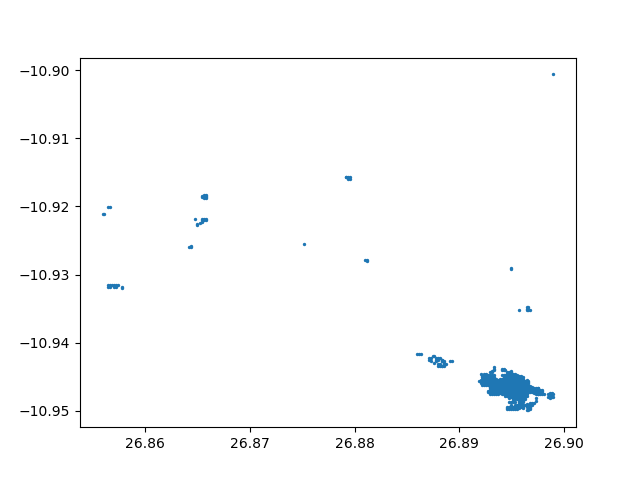

In [119]:
#file = '../Testing/25.25_27.35_-11_-10/statusII_compiled_26.65_-10.3_27.35_-10.0.csv'
#file = '../Training/status_kibali_20m_29.56_3.1_29.615_3.155.csv'
file = 'status_farming_500m_26.85_-10.9_26.9_-10.95.csv'
#file = 'status_LakeNzilo_500.csv'
df = pd.read_csv(file)#,max_rows=20000)


# put all the data into one array
#print(df[0,:])
b56t = (df['B5 Value'].values - df['B6 Value'].values) / (df['B5 Value'].values + df['B6 Value'].values)

clont = df['Center Lon'].values
clatt = df['Center Lat'].values
vegt = df['Percent Vegetation Loss'].values
baret = df['Percent Bare Initial'].values
sart = df['Percent Significant VH Values'].values
swirt = df['Average SWIR1/B'].values
nirgt = df['Average NIR/G'].values
b5stdt = df['B5 Std'].values
b6stdt = df['B6 Std'].values

b56t_ndiff = (b5stdt - b6stdt) / (b5stdt + b6stdt)

datan = np.array([vegt,baret,sart,nirgt,swirt])

print(datan.shape)

datan = np.concatenate((datan,b56t_ndiff[np.newaxis,...]),axis=0)

result = clf.predict(datan.T)

fig = plt.figure()
plt.scatter(clont[result==1],clatt[result==1],s=2)
#plt.show()

#plt.close('all')


In [ ]:
# Load GeoTIFF of Region
def get_image(file):
    with rasterio.open(file,'r') as f:
        # Reads first 3 bands (R,G,B)
        # Currently those are the only bands downloaded, so .read() would have the same results (reads all of the bands available)
        im = f.read([1, 2, 3])
        # Transpose matrix columns to go from rasterio format to cartopy format
        im = np.transpose(im, [1,2,0])
        x = f.bounds
        lon_min = x[0]
        lon_max = x[2]
        lat_min = x[1]
        lat_max = x[3]

        max_val = np.amax(im)
        max_val=50
        im = im/max_val
        im = np.clip(im, 0, 1)
    return (lon_min,lon_max,lat_min,lat_max,im)

In [ ]:
file = 'kibali.tif'
lon_min_kibali,lon_max_kibali,lat_min_kibali,lat_max_kibali,kibali_tif = get_image(file)
file = 'kanunka.tif'
lon_min_kanunka,lon_max_kanunka,lat_min_kanunka,lat_max_kanunka,kanunka_tif = get_image(file)
file = 'australia.tif'  
lon_min_australia,lon_max_australia,lat_min_australia,lat_max_australia,australia_tif = get_image(file)
file = 'mojave.tif'  
lon_min_mojave,lon_max_mojave,lat_min_mojave,lat_max_mojave,mojave_tif = get_image(file)
file = 'musonoi.tif'
lon_min_musonoi,lon_max_musonoi,lat_min_musonoi,lat_max_musonoi,musonoi_tif = get_image(file)
#file = 'water.tif'
#lon_min_water,lon_max_water,lat_min_water,lat_max_water,water_tif = get_image(file)

In [ ]:
#file = 'water_27_-11_27.1_-10.8.tif'
#lon_min_water2,lon_max_water2,lat_min_water2,lat_max_water2,water2_tif = get_image(file)

In [ ]:
"""
fig=plt.figure(figsize=(8,14))
labelsize=10
ticksize=8

for i in range(npoly):
    x, y = polygon[i].exterior.xy
    ax2 = plt.subplot(8,2,2)
    ax2.plot(x,y,'--',color='red')
    ax4 = plt.subplot(8,2,4)
    ax4.plot(x,y,'--',color='red')
    ax6 = plt.subplot(8,2,6)
    ax6.plot(x,y,'--',color='red')
    ax8 = plt.subplot(8,2,8)
    ax8.plot(x,y,'--',color='red')
    ax10 = plt.subplot(8,2,10)
    ax10.plot(x,y,'--',color='red')
    

# Kibali
ax1 = plt.subplot(8,2,1,sharex=ax2,sharey=ax2)
ax1.scatter(data[0,result==1],data[1,result==1],c='green',s=0.15)
ax1.set_xlim([lon_min_kibali,lon_max_kibali])
ax1.set_ylim([lat_min_kibali,lat_max_kibali])
ax1.set_title('Detected Mine Locations: Kibali',size=labelsize)
ax1.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax1.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax1.tick_params(axis="both", labelsize=ticksize)

ax2.imshow(kibali_tif,extent=[lon_min_kibali,lon_max_kibali,lat_min_kibali,lat_max_kibali],aspect='auto')
ax2.set_title('Sentinel-2 2020-21 Composite Image: Kibali',size=labelsize)
ax2.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax2.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax2.tick_params(axis="both", labelsize=ticksize)



# Kanunka
ax3 = plt.subplot(8,2,3,sharex=ax4,sharey=ax4)
ax3.scatter(data[0,result==1],data[1,result==1],c='green',s=0.15)
ax3.set_xlim([lon_min_kanunka,lon_max_kanunka])
ax3.set_ylim([lat_min_kanunka,lat_max_kanunka])
ax3.set_title('Detected Mine Locations: Kanunka',size=labelsize)
ax3.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax3.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax3.tick_params(axis="both", labelsize=ticksize)

ax4.imshow(kanunka_tif,extent=[lon_min_kanunka,lon_max_kanunka,lat_min_kanunka,lat_max_kanunka],aspect='auto')
ax4.set_title('Sentinel-2 2020-21 Composite Image: Kanunka',size=labelsize)
ax4.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax4.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax4.tick_params(axis="both", labelsize=ticksize)


# Musonoi
ax5 = plt.subplot(8,2,5,sharex=ax6,sharey=ax6)
ax5.scatter(data[0,result==1],data[1,result==1],c='green',s=0.15)
ax5.set_xlim([lon_min_musonoi,lon_max_musonoi])
ax5.set_ylim([lat_min_musonoi,lat_max_musonoi])
ax5.set_title('Detected Mine Locations: Musonoi',size=labelsize)
ax5.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax5.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax5.tick_params(axis="both", labelsize=ticksize)

ax6.imshow(musonoi_tif,extent=[lon_min_musonoi,lon_max_musonoi,lat_min_musonoi,lat_max_musonoi],aspect='auto')
ax6.set_title('Sentinel-2 2020-21 Composite Image: Musonoi',size=labelsize)
ax6.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax6.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax6.tick_params(axis="both", labelsize=ticksize)


# Australia
ax7 = plt.subplot(8,2,7,sharex=ax8,sharey=ax8)
ax7.scatter(data[0,result==1],data[1,result==1],c='green',s=0.15)
ax7.set_xlim([lon_min_australia,lon_max_australia])
ax7.set_ylim([lat_min_australia,lat_max_australia])
ax7.set_title('Detected Mine Locations: Australia',size=labelsize)
ax7.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax7.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax7.tick_params(axis="both", labelsize=ticksize)

ax8.imshow(australia_tif,extent=[lon_min_australia,lon_max_australia,lat_min_australia,lat_max_australia],aspect='auto')
ax8.set_title('Sentinel-2 2020-21 Composite Image: Australia',size=labelsize)
ax8.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax8.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax8.tick_params(axis="both", labelsize=ticksize)


# Mojave
ax9 = plt.subplot(8,2,9,sharex=ax10,sharey=ax10)
ax9.scatter(data[0,result==1],data[1,result==1],c='green',s=0.15)
ax9.set_xlim([lon_min_mojave,lon_max_mojave])
ax9.set_ylim([lat_min_mojave,lat_max_mojave])
ax9.set_title('Detected Mine Locations: Mojave',size=labelsize)
ax9.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax9.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax9.tick_params(axis="both", labelsize=ticksize)
ax9.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))

ax10.imshow(mojave_tif,extent=[lon_min_mojave,lon_max_mojave,lat_min_mojave,lat_max_mojave],aspect='auto')
#ax10.set_aspect(2.5)
ax10.set_title('Sentinel-2 2020-21 Composite Image: Mojave',size=labelsize)
ax10.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax10.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax10.tick_params(axis="both", labelsize=ticksize)

# Water
ax12 = plt.subplot(7,2,12)
ax12.imshow(water_tif*2,extent=[lon_min_water,lon_max_water,lat_min_water,lat_max_water],aspect='auto')
#ax10.set_aspect(2.5)
ax12.set_title('Sentinel-2 2020-21 Composite Image: Lake Nzilo',size=labelsize)
ax12.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax12.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax12.tick_params(axis="both", labelsize=ticksize)

ax11 = plt.subplot(8,2,11,sharex=ax12,sharey=ax12)
ax11.scatter(data[0,result==1],data[1,result==1],c='green',s=0.15)
ax11.set_xlim([lon_min_water,lon_max_water])
ax11.set_ylim([lat_min_water,lat_max_water])
ax11.set_title('Detected Mine Locations: Lake Nzilo',size=labelsize)
ax11.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax11.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax11.tick_params(axis="both", labelsize=ticksize)
ax11.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))

# Water2
#ax14 = plt.subplot(8,2,14)
#ax14.imshow(water_tif*2,extent=[lon_min_water,lon_max_water,lat_min_water,lat_max_water],aspect='auto')
#ax14.set_aspect(2.5)
#ax14.set_title('Sentinel-2 2020-21 Composite Image: Lake Nzilo',size=labelsize)
#ax14.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
#ax14.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
#ax14.tick_params(axis="both", labelsize=ticksize)

ax13 = plt.subplot(8,2,13)#,sharex=ax14,sharey=ax14)
ax13.scatter(data[0,result==1],data[1,result==1],c='green',s=0.15)
#ax13.set_xlim([lon_min_water,lon_max_water])
#ax13.set_ylim([lat_min_water,lat_max_water])
ax13.set_xlim([27,27.1])
ax13.set_ylim([-11,-10.8])
ax13.set_title('Detected Mine Locations: Lake II',size=labelsize)
ax13.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax13.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax13.tick_params(axis="both", labelsize=ticksize)
ax13.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))

ax15 = plt.subplot(8,2,15)#,sharex=ax16,sharey=ax16)
ax15.scatter(data[0,result==1],data[1,result==1],c='green',s=0.15)
#ax13.set_xlim([lon_min_water,lon_max_water])
#ax13.set_ylim([lat_min_water,lat_max_water])
ax15.set_xlim([26.85,26.9])
ax15.set_ylim([-10.95,-10.9])
ax15.set_title('Detected Mine Locations: Farming',size=labelsize)
ax15.set_xlabel(r"Longitude [$^\circ$]",size=labelsize)
ax15.set_ylabel(r"Latitude [$^\circ$]",size=labelsize)
ax15.tick_params(axis="both", labelsize=ticksize)
ax15.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))

fig.tight_layout()

#plt.close('all')
"""
#display(fig)


In [ ]:
#file = '../Testing/25.25_27.35_-11_-10/statusII_compiled_26.65_-10.3_27.35_-10.0.csv'
#file = '../Training/status_kibali_20m_29.56_3.1_29.615_3.155.csv'
file = 'status_farming_200m_26.85_-10.9_26.9_-10.95.csv'
#file = 'status_LakeNzilo_200.csv'
df = pd.read_csv(file)#,max_rows=20000)


# put all the data into one array
#print(df[0,:])
b56t = (df['B5 Value'].values - df['B6 Value'].values) / (df['B5 Value'].values + df['B6 Value'].values)

clont = df['Center Lon'].values
clatt = df['Center Lat'].values
vegt = df['Percent Vegetation Loss'].values
baret = df['Percent Bare Initial'].values
sart = df['Percent Significant VH Values'].values
swirt = df['Average SWIR1/B'].values
nirgt = df['Average NIR/G'].values
b5stdt = df['B5 Std'].values
b6stdt = df['B6 Std'].values

b56t_ndiff = (b5stdt - b6stdt) / (b5stdt + b6stdt)

datan = np.array([vegt,baret,sart,nirgt,swirt])

print(datan.shape)

datan = np.concatenate((datan,b56t_ndiff[np.newaxis,...]),axis=0)

result = clf.predict(datan.T)

fig = plt.figure()
plt.scatter(clont[result==1],clatt[result==1],s=2)
#plt.show()

#plt.close('all')


In [ ]:
from simplekml import (Kml, AltitudeMode,Color)
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from palettable import colorbrewer
import numpy.ma as ma
import matplotlib as mpl
mpl.cm.get_cmap
import matplotlib.cm as cm
from sys import exit
from tqdm import tqdm

def make_kml(lon,lat,alt,colorrange,outname):
    kml = Kml()
    npnts = len(lon)
    for i in tqdm(range(npnts)):
        #pnt = kml.newpoint(coords=[(lon[i],lat[i],alt[i])],gxaltitudemode='relativeToSeaFloor')
        pnt = kml.newpoint(coords=[(lon[i],lat[i],alt[i])],altitudemode='absolute')
        #pnt = kml.newpoint(coords=[(lon[i],lat[i],alt[i])],altitudemode='relativetoground')
        #pnt.style.labelstyle.color = Color.rgb(int(colorrange[i]),0,0,255)
        pnt.style.iconstyle.color = Color.rgb(int(colorrange[i]),0,0,int(colorrange[i]))
        pnt.style.iconstyle.icon.href = 'http://earth.google.com/images/kml-icons/track-directional/track-none.png'
    kml.save(outname)

In [ ]:
lon = df[result==1,0]
lat = df[result==1,1]

color = 255*np.ones(len(lon))
alt=np.zeros(len(color))
make_kml(lon,lat,alt,color,'compiled_26.65_-10.3_27.35_-10.0.kml')